In [1]:
import os
import random
import tensorflow as tf
# !pip install tqdm
from tqdm import tqdm
import numpy as np
# !pip skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

ModuleNotFoundError: No module named 'tensorflow.compat'

In [35]:
batch_size = 8
width = 128
height = 128
channel = 3
train_dir = "dataset/stage1_train/" 
test_dir = "dataset/stage1_test/" 

In [9]:
train_ids = next(os.walk(train_dir))[1]
test_ids = next(os.walk(test_dir))[1] 
np.random.seed(10)

In [12]:
x_train = np.zeros((len(train_ids),width,height, channel),dtype=np.uint8)
y_train = np.zeros((len(train_ids),width,height, 1), dtype=np.bool)

E:\anaconda3\envs\keras_dl\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [37]:
for i,j in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_dir + j
    img = imread(path + "/images/" + j + ".png")[:,:,:channel]
    img = resize(img, (height,width), mode="constant", preserve_range=True)
    x_train[i] = img
    
    mask = np.zeros((width,height, 1), dtype=np.bool)
    
    for mask_ in next(os.walk(path + "/masks/"))[2]:
        mask1 = imread(path + "/masks/" + mask_)
        mask1 = resize(mask1, (height,width), mode="constant", preserve_range=True)
        mask1 = np.expand_dims(mask1, axis=-1)
        
        mask = np.maximum(mask, mask1)
    
    y_train[i] = mask
    


  0%|                                                                                          | 0/670 [00:00<?, ?it/s]E:\anaconda3\envs\keras_dl\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys

 14%|███████████▌                                                                     | 96/670 [00:51<05:56,  1.61it/s]


 29%|███████████████████████▌                                                        | 197/670 [01:22<02:14,  3.51it/s]


 45%|███████████████████████████████████▊                                            | 300/670 [02:15<01:34,  3.90it/s]


 61%|█████████████████████████████████████████████████                               | 411/670 [02:59<00:44,  5.86it/s]


 78%|██████████████████████████████████████████████████████████████▍                 | 523/670 [03:41<00:59,  2.49it/s]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 626/670 [04:19<00:09,  4.72it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [04:33<00:00,  2.45it/s]


In [38]:
x_test = np.zeros((len(test_ids),width,height, channel), dtype=np.bool)
l=[]

for i,j in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_dir + j
    img = imread(path + "/images/" + j + ".png")[:,:,:channel]
    l.append([img.shape[0], img.shape[1]])
    img = resize(img, (height,width), mode="constant", preserve_range=True)
    x_test[i] = img
    

E:\anaconda3\envs\keras_dl\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 44.07it/s]


In [48]:
image_data_generator = ImageDataGenerator(shear_range = 0.5,
                                          rotation_range = 45,
                                          zoom_range = 0.2,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          fill_mode= "reflect")

mask_data_generator = ImageDataGenerator(shear_range = 0.5,
                                          rotation_range = 45,
                                          zoom_range = 0.2,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          fill_mode= "reflect")


image_data_generator.fit(x_train[:int(x_train.shape[0]*0.9)], augment=True, seed = 42)
mask_data_generator.fit(y_train[:int(y_train.shape[0]*0.9)], augment=True, seed = 42)



x_datagen = image_data_generator.flow(x_train[int(x_train.shape[0]*0.9):],
                                      batch_size = batch_size,
                                      shuffle = True,
                                      seed = 42)
y_datagen = mask_data_generator.flow(y_train[int(y_train.shape[0]*0.9):],
                                      batch_size = batch_size,
                                      shuffle = True,
                                      seed = 42)

In [50]:
image_data_generator_val = ImageDataGenerator()
mask_data_generator_val = ImageDataGenerator()

image_data_generator_val.fit(x_train[int(x_train.shape[0]*0.9):], augment=True, seed = 42)
mask_data_generator_val.fit(y_train[int(y_train.shape[0]*0.9):], augment=True, seed = 42)


x_datagen_val = image_data_generator.flow(x_train[int(x_train.shape[0]*0.9):],
                                      batch_size = batch_size,
                                      shuffle = True,
                                      seed = 42)
y_datagen_val = mask_data_generator.flow(y_train[int(y_train.shape[0]*0.9):],
                                      batch_size = batch_size,
                                      shuffle = True,
                                      seed = 42)

In [51]:
train_generator = zip(x_datagen,y_datagen)
validation_generator = zip(x_datagen_val,y_datagen_val)

In [53]:
inputs = tf.keras.layers.Input((height, width, channel))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [57]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    validation_steps = 10,
                    steps_per_epoch = 250,
                    epochs = 3)

Epoch 1/3
250/250 [==============================] - 129s 518ms/step - loss: 0.2253 - accuracy: 0.8624 - val_loss: 0.1348 - val_accuracy: 0.9046
Epoch 2/3
250/250 [==============================] - 129s 518ms/step - loss: 0.1248 - accuracy: 0.9077 - val_loss: 0.0979 - val_accuracy: 0.9209
Epoch 3/3
250/250 [==============================] - 130s 519ms/step - loss: 0.1089 - accuracy: 0.9136 - val_loss: 0.1098 - val_accuracy: 0.9119


In [60]:
model.save("model/unet.h5")

In [61]:
model = load_model("model/unet.h5")

predictions_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
predictions_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
predictions_test = model.predict(x_test, verbose=1)

predictions_train_ = (predictions_train>0.5).astype(np.uint8)
predictions_val_ = (predictions_train>0.5).astype(np.uint8)
predictions_test_ = (predictions_train>0.5).astype(np.uint8)

3/3 [==============================] - 1s 187ms/step


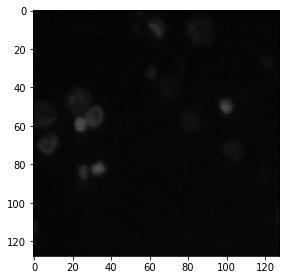

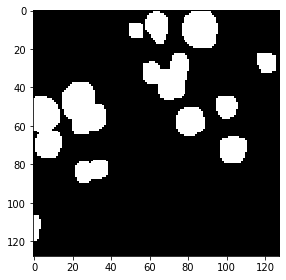

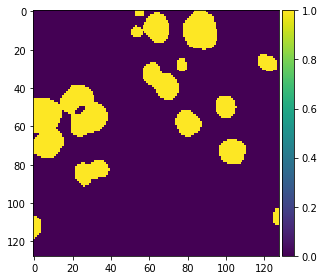

In [70]:
random_number = random.randint(0, len(predictions_train_))
imshow(x_train[random_number])
plt.show()

imshow(np.squeeze(y_train[random_number]))
plt.show()

imshow(np.squeeze(predictions_train_[random_number]))
plt.show()
